<a href="https://colab.research.google.com/github/aliemadabdo/Automatic-vehicle-number-plate-detection-and-smart-garage/blob/main/Car_license_plate_detection_and_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from skimage import io
from shutil import copy
import pytesseract as pt
import plotly.express as px
import xml.etree.ElementTree as xet
from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/ultralytics/yolov5 # clone yolov5 repo
!pip install -r ./yolov5/requirements.txt  #install the requirements for yolov5 
                                           #install the packages listed in the requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir /content/yolov5/data_images/
!mkdir /content/yolov5/data_images/test/
!mkdir /content/yolov5/data_images/train/

mkdir: cannot create directory ‘/content/yolov5/data_images/’: File exists
mkdir: cannot create directory ‘/content/yolov5/data_images/test/’: File exists
mkdir: cannot create directory ‘/content/yolov5/data_images/train/’: File exists


In [ ]:
!cat ./yolov5/requirements.txt #propable error for libraries versions

# YOLOv5 requirements
# Usage: pip install -r requirements.txt

# Base ------------------------------------------------------------------------
gitpython
ipython  # interactive notebook
matplotlib>=3.2.2
numpy>=1.18.5
opencv-python>=4.1.1
Pillow>=7.1.2
psutil  # system resources
PyYAML>=5.3.1
requests>=2.23.0
scipy>=1.4.1
thop>=0.1.1  # FLOPs computation
torch>=1.7.0  # see https://pytorch.org/get-started/locally (recommended)
torchvision>=0.8.1
tqdm>=4.64.0
# protobuf<=3.20.1  # https://github.com/ultralytics/yolov5/issues/8012

# Logging ---------------------------------------------------------------------
tensorboard>=2.4.1
# clearml>=1.2.0
# comet

# Plotting --------------------------------------------------------------------
pandas>=1.1.4
seaborn>=0.11.0

# Export ----------------------------------------------------------------------
# coremltools>=6.0  # CoreML export
# onnx>=1.12.0  # ONNX export
# onnx-simplifier>=0.4.1  # ONNX simplifier
# nvidia-pyindex  # TensorRT export
# 

In [ ]:
# !cat aslanahmedov/number-plate-detection

In [ ]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # 600 is permession code means that only the owner can read and write to the file 
 #popable error when copy API at last
!kaggle datasets download -d aslanahmedov/number-plate-detection # from ahmed hussin kaggle
!unzip /content/number-plate-detection.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
number-plate-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/number-plate-detection.zip
replace TEST/TEST.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: TEST/TEST.jpeg          
  inflating: TEST/TEST.mp4           
  inflating: data.yaml               
  inflating: images/N1.jpeg          
  inflating: images/N1.xml           
  inflating: images/N100.jpeg        
  inflating: images/N100.xml         
  inflating: images/N101.jpeg        
  inflating: images/N101.xml         
  inflating: images/N102.jpeg        
  inflating: images/N102.xml         
  inflating: images/N103.jpeg        
  inflating: images/N103.xml         
  inflating: images/N104.jpeg        
  inflating: images/N104.xml         
  inflating: images/N105.jpeg        
  inflating: images/N105.xml         
  inflating: images/N106.jpeg        
  inflating: images/N106.xml        

In [ ]:
path = glob('/content/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

for filename in path:
    info = xet.parse(filename)
    root = info.getroot()
    
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/images/N7.xml,1149,1358,649,702
1,/content/images/N236.xml,313,380,111,141
2,/content/images/N176.xml,195,383,320,358
3,/content/images/N241.xml,251,542,308,385
4,/content/images/N128.xml,58,221,198,271


In [ ]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/images/{name}'
    
    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,/content/images/N7.xml,1149,1358,649,702,/content/images/N7.jpeg,1920,1080
1,/content/images/N236.xml,313,380,111,141,/content/images/N236.jpeg,462,290
2,/content/images/N176.xml,195,383,320,358,/content/images/N176.jpeg,500,448
3,/content/images/N241.xml,251,542,308,385,/content/images/N241.jpeg,800,600
4,/content/images/N128.xml,58,221,198,271,/content/images/N128.jpeg,500,399


In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/images/N7.xml,1149,1358,649,702,/content/images/N7.jpeg,1920,1080,0.652865,0.625463,0.108854,0.049074
1,/content/images/N236.xml,313,380,111,141,/content/images/N236.jpeg,462,290,0.750000,0.434483,0.145022,0.103448
2,/content/images/N176.xml,195,383,320,358,/content/images/N176.jpeg,500,448,0.578000,0.756696,0.376000,0.084821
3,/content/images/N241.xml,251,542,308,385,/content/images/N241.jpeg,800,600,0.495625,0.577500,0.363750,0.128333
4,/content/images/N128.xml,58,221,198,271,/content/images/N128.jpeg,500,399,0.279000,0.587719,0.326000,0.182957


In [ ]:
# 1+1

In [ ]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [ ]:
train_folder = '/content/yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = '/content/yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% |  1% |


In [ ]:
!python /content/yolov5/train.py --data /content/data.yaml --cfg /content/yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 50

train: weights=yolov5/yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 2.69 KiB | 2.69 MiB/s, done.
From https://github.com/ultralytics/yolov5
   b8731d8..b005788  master               -> origin/mast

In [ ]:
!python /content/yolov5/export.py --weight /content/yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['/content/yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-111-gb8731d8 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.13.1+cu116...
TorchScript: export success ✅ 3.3s, saved as /content/yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.13.1...
ONNX: export success ✅ 1.1s, saved as /content/yolov5/runs/train/Model/weights/best.onnx (27.2 MB)

Exp


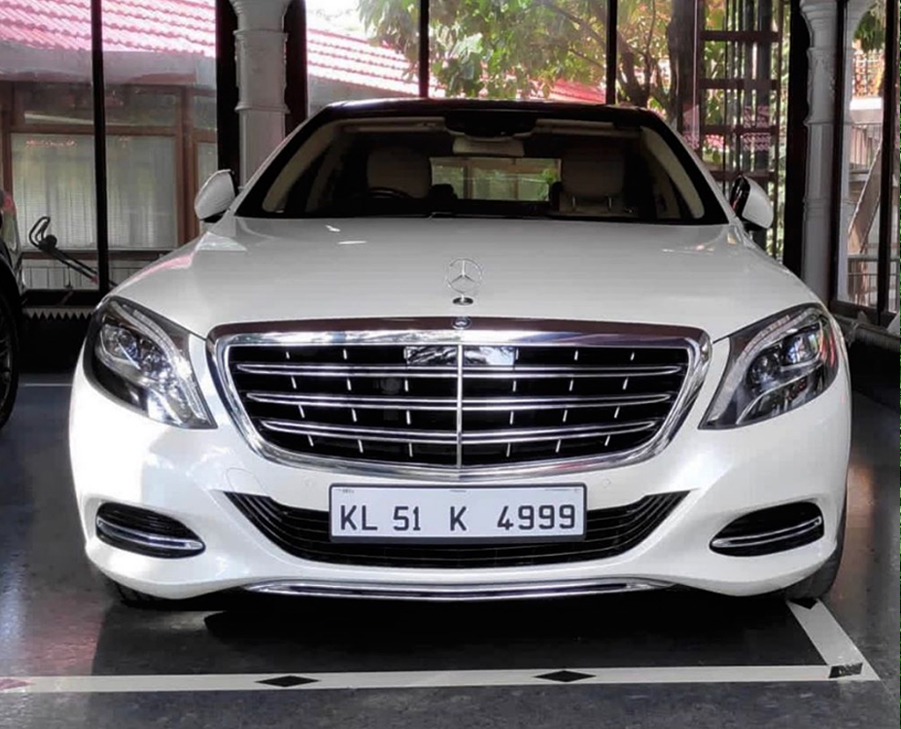

In [ ]:
# LOAD THE IMAGE
img = io.imread('/content/TEST/TEST.jpeg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()


In [ ]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('/content/yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [ ]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [ ]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [ ]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [ ]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    if 0 in roi.shape:
        return 'no number'
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [ ]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
!pip install pytesseract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import pytesseract
# pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'


In [ ]:
# test
img = io.imread('/content/TEST/TEST.jpeg')
results = yolo_predictions(img,net)


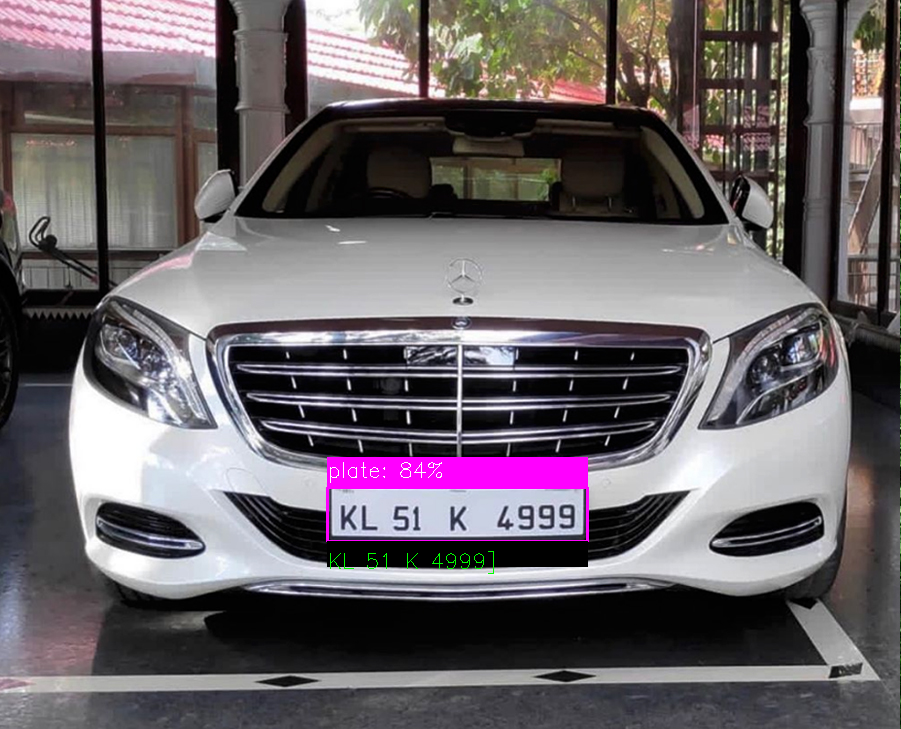

In [ ]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/content/Number Plate detection on Recorded Video.mp4')
 
 
# Check if camera opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")
 
# Read until video is completed
while (cap.isOpened()):

    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
     
      #results = yolo_predictions(frame,net)

      cv2.namedWindow('YOLO',cv2.WINDOW_KEEPRATIO)
      cv2_imshow(frame)
        # Display the resulting frame
        # cv2_imshow('Frame', frame)
 
        # Press Q on keyboard to  exit
      if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    # Break the loop
    else:
        break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
import psutil
print(psutil.virtual_memory())


svmem(total=13616324608, available=12366880768, percent=9.2, used=929669120, free=4645564416, active=2212081664, inactive=6231175168, buffers=428777472, cached=7612313600, shared=1351680, slab=394129408)
